# 1. Loading Packages 

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer # VADER for sentiment
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tabulate import tabulate

# One-time downloads for NLTK (if you haven't done them)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4') # For WordNetLemmatizer
# nltk.download('vader_lexicon') # For VADER
# nltk.download('punkt_tab') # For word tokenization

# 2. Loading data

In [4]:
# Load dataset
try:
    df = pd.read_csv("../data/amazon_books_reviews.csv")
except FileNotFoundError:
    print("Error: amazon_books_reviews.csv not found. Please check the path.")
    exit()

In [3]:

# Display basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             10000 non-null  float64
 1   title              10000 non-null  object 
 2   text               10000 non-null  object 
 3   images             10000 non-null  object 
 4   asin               10000 non-null  object 
 5   parent_asin        10000 non-null  object 
 6   user_id            10000 non-null  object 
 7   timestamp          10000 non-null  int64  
 8   helpful_vote       10000 non-null  int64  
 9   verified_purchase  10000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 713.0+ KB
None


In [4]:
display(df)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Not a watercolor book! Seems like copies imo.,It is definitely not a watercolor book. The p...,[{'small_image_url': 'https://m.media-amazon.c...,B09BGPFTDB,B09BGPFTDB,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1642399598485,0,True
1,5.0,Updated: after 1st arrived damaged this one is...,Updated: after first book arrived very damaged...,[],0593235657,0593235657,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640629604904,1,True
2,5.0,Excellent! I love it!,I bought it for the bag on the front so it pai...,[],1782490671,1782490671,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640383495102,0,True
3,5.0,Updated after 1st arrived damaged. Excellent,Updated: after 1st arrived damaged the replace...,[],0593138228,0593138228,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640364906602,0,False
4,5.0,Beautiful patterns!,I love this book! The patterns are lovely. I ...,[{'small_image_url': 'https://m.media-amazon.c...,0823098079,0823098079,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1637312253230,0,True
...,...,...,...,...,...,...,...,...,...,...
9995,5.0,A well researched book of facts and accomplish...,"This book is a short, compressed look at the l...",[],0894906844,0894906844,AFQ7WYW4KSH4VI5OVXCP2GV6PBRA,1574825806573,0,False
9996,5.0,An enjoyable book of wisdom and encouragement,This is a charming book written by a smart wom...,[],B07KB65NMS,B07KB65NMS,AFQ7WYW4KSH4VI5OVXCP2GV6PBRA,1574655470598,0,False
9997,5.0,An enchanting book,I completely enjoyed this short look into the ...,[],0812989341,0812989341,AFQ7WYW4KSH4VI5OVXCP2GV6PBRA,1572295102752,0,False
9998,5.0,Amazing detail and a bounty of information,This is a great deal of necessary information ...,[],0807858838,0807858838,AFQ7WYW4KSH4VI5OVXCP2GV6PBRA,1571006381867,4,False


In [5]:
# check missing values
print(df.isnull().sum())
# check the distribution of the ratings
print(df['rating'].value_counts().sort_index())


rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64
rating
1.0     150
2.0     360
3.0    1066
4.0    2597
5.0    5827
Name: count, dtype: int64


There **no missing value** in this dataset.

# 3. Data Preprocessing

## 3.1 Text preprocessing

- Text preprocessing (lowercase conversion, HTML tag removal, punctuation cleaning, etc.)

In [5]:
df.dropna(subset=['text', 'rating'], inplace=True) # Ensure 'text' and 'rating' are not NaN
# Filter for 1-star and 5-star reviews for the comparative analysis
df_1_5 = df[df['rating'].isin([1, 5])].copy()

sid = SentimentIntensityAnalyzer()
# VADER works best on raw text with punctuation, so we apply it before text cleaning
df_1_5['sentiment_score'] = df_1_5['text'].apply(lambda text: sid.polarity_scores(str(text))['compound'])
print(df_1_5['sentiment_score'])

0       0.6853
1       0.1298
2       0.0000
3       0.2023
4       0.9730
         ...  
9995    0.8481
9996    0.9957
9997    0.9835
9998    0.9382
9999    0.9931
Name: sentiment_score, Length: 5977, dtype: float64


In [6]:
import re

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Add custom stopwords to filter out noise from n-grams
custom_stopwords = ['book', 'one', 'author','read', 'story','reading','page', 'really', 'time','life', 'also','make','reader','first','would', 'get','way',
                     'say', 'find', 'many','novel','character', 'writing', 'child', 'people', 'could',
                     'chapter', 'year', 'york', 'ago','later', 'receipe']

stop_words.update(custom_stopwords)

#Basic text preprocessing for word cloud generation
def preprocess_text(text):
    if not isinstance(text, str): # Handle potential non-string data
        return ""
    # Lowercase
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    # remove <br />
    text = re.sub(r'<br />', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1] # len(token) > 1 to remove short tokens
    return " ".join(processed_tokens) # Return as a string for some analyses, or list of tokens

# Apply preprocessing to the 'text' and 'title' column of filtered DataFrames
df_1_5['processed_text'] = df_1_5['text'].apply(preprocess_text) + " " + df_1_5['title'].apply(preprocess_text)

print(df_1_5.columns)

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'sentiment_score',
       'processed_text'],
      dtype='object')


## 3.2 Upsampling Imbalanced Data

In [7]:
# Text statistics
print("Calculating processed text statistics...")
df_1_5['text_length'] = df_1_5['processed_text'].apply(lambda x: len(str(x)))
df_1_5['word_count'] = df_1_5['processed_text'].apply(lambda x: len(str(x).split()))
df_1_5['avg_word_length'] = df_1_5['processed_text'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
)

# Vocabulary richness (unique words / total words)
df_1_5['vocabulary_richness'] = df_1_5['processed_text'].apply(
    lambda x: len(set(str(x).lower().split())) / len(str(x).split()) if str(x).split() else 0
)

print("Text length:")
print(tabulate(df_1_5.groupby('rating')['text_length'].describe().round(3), headers='keys', tablefmt='pretty', showindex=False))
print("\nWord count:")
print(tabulate(df_1_5.groupby('rating')['word_count'].describe().round(3), headers='keys', tablefmt='pretty', showindex=False))
print("\nAvg word length:")
print(tabulate(df_1_5.groupby('rating')['avg_word_length'].describe().round(3), headers='keys', tablefmt='pretty', showindex=False))
print("\nVocabulary richness:")
print(tabulate(df_1_5.groupby('rating')['vocabulary_richness'].describe().round(3), headers='keys', tablefmt='pretty', showindex=False))

Calculating processed text statistics...
Text length:
+--------+--------+---------+-----+-------+-------+-------+---------+
| count  |  mean  |   std   | min |  25%  |  50%  |  75%  |   max   |
+--------+--------+---------+-----+-------+-------+-------+---------+
| 150.0  | 364.78 | 449.064 | 8.0 | 86.5  | 156.5 | 452.0 | 2114.0  |
| 5827.0 | 658.19 | 833.991 | 1.0 | 117.0 | 385.0 | 912.0 | 15731.0 |
+--------+--------+---------+-----+-------+-------+-------+---------+

Word count:
+--------+--------+---------+-----+-------+------+-------+--------+
| count  |  mean  |   std   | min |  25%  | 50%  |  75%  |  max   |
+--------+--------+---------+-----+-------+------+-------+--------+
| 150.0  | 50.34  | 60.294  | 1.0 | 12.25 | 23.5 | 63.75 | 295.0  |
| 5827.0 | 90.346 | 113.309 | 0.0 | 17.0  | 54.0 | 125.0 | 2211.0 |
+--------+--------+---------+-----+-------+------+-------+--------+

Avg word length:
+--------+-------+-------+-----+-------+-------+-------+--------+
| count  | mean  |  s

In [8]:
from sklearn.utils import resample

# Separate majority and minority classes
df_minority = df_1_5[df_1_5['rating'] == 1]
df_majority = df_1_5[df_1_5['rating'] == 5]

print("Original class distribution:")
print(f"1-star reviews: {len(df_minority)}")
print(f"5-star reviews: {len(df_majority)}")

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
# combine the upsampled 1_star with 5_star
df_balanced = pd.concat([df_majority, df_minority_upsampled])

print("\nBalanced class distribution:")
print(df_balanced['rating'].value_counts())

Original class distribution:
1-star reviews: 150
5-star reviews: 5827

Balanced class distribution:
rating
5.0    5827
1.0    5827
Name: count, dtype: int64


## 3.3 Data Scaling and Transformation

- Because sentiment scores may be negative and the distribution is relatively symmetrical, and its value range is usually between -1 and +1, it is appropriate to use **StandardScaler** to standardize data to a normal distribution with a mean of 0 and a standard deviation of 1.
- Because statistical feature data such as text length and number of words may have a large range of values, it is necessary to maintain a relative proportional relationship. And these values are always positive, so **MinMaxScaler** is used to scale these feature data to the [0, 1] interval.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF features for unigrams and bigrams
tfidf_unigram = TfidfVectorizer(max_features = 3000, ngram_range = (1, 1), stop_words = 'english')
tfidf_bigram = TfidfVectorizer(max_features = 2000, ngram_range = (2, 2), stop_words = 'english')

# Fit and transform TF-IDF features
X_unigram = tfidf_unigram.fit_transform(df_balanced['processed_text'])
X_bigram = tfidf_bigram.fit_transform(df_balanced['processed_text'])

print(f"Unigram features shape: {X_unigram.shape}")
print(f"Bigram features shape: {X_bigram.shape}")

# get sentiment score and stats(text_length, word_count, avg_word_length, vocabulary_richness)
X_sentiment = df_balanced[['sentiment_score']].values 
X_stats = df_balanced[['text_length', 'word_count', 'avg_word_length', 'vocabulary_richness']].values 

# Scale numerical features
scaler_sentiment = StandardScaler()
scaler_stats = MinMaxScaler()
X_sentiment_scaled = scaler_sentiment.fit_transform(X_sentiment)
X_stats_scaled = scaler_stats.fit_transform(X_stats)

# Combine all features
X_combined = np.hstack([X_unigram.toarray(), X_bigram.toarray(), X_sentiment_scaled, X_stats_scaled])
y = (df_balanced['rating'] == 5).astype(int)  # 0 for 1-star, 1 for 5-star

print(f"Final feature matrix shape: {X_combined.shape}")
print(f"Final target matrix shape: {y.shape}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Feature matrix: {X_combined}")
print(f"Target matrix: {y}")

Unigram features shape: (11654, 3000)
Bigram features shape: (11654, 2000)
Final feature matrix shape: (11654, 5005)
Final target matrix shape: (11654,)
Target distribution: [5827 5827]
Feature matrix: [[0.         0.         0.         ... 0.00542741 0.54487179 0.58333333]
 [0.         0.         0.         ... 0.00904568 0.39230769 0.95      ]
 [0.         0.         0.         ... 0.00587969 0.52662722 0.61538462]
 ...
 [0.         0.         0.         ... 0.00587969 0.47337278 0.92307692]
 [0.         0.         0.         ... 0.01040253 0.42140468 1.        ]
 [0.         0.         0.         ... 0.00949796 0.41758242 0.9047619 ]]
Target matrix: 1       1
2       1
3       1
4       1
7       1
       ..
4058    0
777     0
9298    0
1891    0
2634    0
Name: rating, Length: 11654, dtype: int64


## 3.4. Feature Engineering and Split the data into training and test sets

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Create feature matrices for different model types
# For MultinomialNB: only use TF-IDF features (non-negative)
X_tfidf_only = np.hstack([X_unigram.toarray(), X_bigram.toarray()])

# For other models: use all features
X_all_features = X_combined

# Split both feature matrices
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf_only, y, test_size=0.2, random_state=42, stratify=y
)
# For other models: use all features
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all_features, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train_all.shape}")
print(f"Test set shape: {X_test_all.shape}")
print(f"Training set class distribution: {np.bincount(y_train_all)}")
print(f"Test set class distribution: {np.bincount(y_test_all)}")

Training set shape: (9323, 5005)
Test set shape: (2331, 5005)
Training set class distribution: [4661 4662]
Test set class distribution: [1166 1165]


# 4. Model Selection

## 4.1 Candidate Models

**1. Logistic Regression**

**Reasons for selection:** As a standard baseline for text classification, it is suitable for linear features such as TF-IDF, has fast training speed, is suitable for large-scale data, can clearly see the importance of features and is not prone to overfitting.

**2. Random Forest**

**Reasons for selection:** Multiple decision trees vote to resist overfitting. Its nonlinear pattern can capture complex text patterns. It can automatically identify important features and is insensitive to noise and outliers.

**3. Multinomial Naive Bayes**

**Reasons for selection:** Designed specifically for text data, it has good processing effects on sparse features (rare words), and has extremely fast training and prediction speeds.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Define models and their parameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'class_weight': ['balanced', None],
            'solver': ['lbfgs', 'liblinear']
        },
        'feature_type': 'all'
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        'feature_type': 'all'
    },
    'Multinomial Naive Bayes': {
        'model': MultinomialNB(),
        'params': {
            'alpha': [0.1, 0.5, 1.0, 2.0],
            'fit_prior': [True, False]
        },
        'feature_type': 'tfidf'
    }
}

# 5. Train prediction models and Hyperparameter Tuning

**Feature adaptability to the model：**
- Logistic Regression and Random Forest: use **all features** (TF-IDF + sentiment + statistics).
- Naive Bayes: only use **TF-IDF features** (to **avoid negative value** problems).

Systematic hyperparameter tuning using GridSearchCV:
- Logistic regression: C value, class weight, solver
- Random forest: number of trees, maximum depth, number of split samples, class weight
- Naive Bayes: smoothing parameter alpha

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Train and evaluate models
def train_and_evaluate_models(models, X_train_tfidf, y_train_tfidf, X_test_tfidf, y_test_tfidf, X_train_all, y_train_all, X_test_all, y_test_all):
    results = {}
    best_models = {}

    for name, model_info in models.items():
        print(f"\nTraining {name}...")
        
        # Select appropriate feature matrices based on model type
        if model_info['feature_type'] == 'tfidf':
            X_train_model = X_train_tfidf
            X_test_model = X_test_tfidf
            y_train_model = y_train_tfidf
            y_test_model = y_test_tfidf
        else:  # 'all'
            X_train_model = X_train_all
            X_test_model = X_test_all
            y_train_model = y_train_all
            y_test_model = y_test_all
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            model_info['model'],
            model_info['params'],
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='f1',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train_model, y_train_model)
        
        # Get best model
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        
        # Make predictions
        y_pred = best_model.predict(X_test_model)
        
        # Calculate metrics(weighted average for all classes)
        accuracy = accuracy_score(y_test_model, y_pred)
        precision = precision_score(y_test_model, y_pred, average='weighted')
        recall = recall_score(y_test_model, y_pred, average='weighted')
        f1 = f1_score(y_test_model, y_pred, average='weighted')
        
        # Calculate class-specific metrics(pos_label=0 for 1-star, pos_label=1 for 5-star)
        precision_1star = precision_score(y_test_model, y_pred, pos_label=0)
        recall_1star = recall_score(y_test_model, y_pred, pos_label=0)
        f1_1star = f1_score(y_test_model, y_pred, pos_label=0)
        
        precision_5star = precision_score(y_test_model, y_pred, pos_label=1)
        recall_5star = recall_score(y_test_model, y_pred, pos_label=1)
        f1_5star = f1_score(y_test_model, y_pred, pos_label=1)
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'precision_1star': precision_1star,
            'recall_1star': recall_1star,
            'f1_1star': f1_1star,
            'precision_5star': precision_5star,
            'recall_5star': recall_5star,
            'f1_5star': f1_5star,
            'best_params': grid_search.best_params_,
            'y_pred': y_pred
        }
        
        print(f"Best parameters: {grid_search.best_params_}") 
        print(f"Best CV score: {grid_search.best_score_:.3f}")
        print(f"Test accuracy (weighted average): {accuracy:.3f}")
        print(f"Test precision (weighted average): {precision:.3f}")
        print(f"Test recall (weighted average): {recall:.3f}")
        print(f"Test f1 (weighted average): {f1:.3f}")
        print(f"Test F1-score (1-star): {f1_1star:.3f}")
        print(f"Test F1-score (5-star): {f1_5star:.3f}")
        print(f"Test precision (1-star): {precision_1star:.3f}")
        print(f"Test recall (1-star): {recall_1star:.3f}")
        print(f"Test f1 (1-star): {f1_1star:.3f}")
        print(f"Test precision (5-star): {precision_5star:.3f}")
        print(f"Test recall (5-star): {recall_5star:.3f}")
        print(f"Test f1 (5-star): {f1_5star:.3f}")

    return results, best_models


# Train and evaluate models
results, best_models = train_and_evaluate_models(models, X_train_tfidf, y_train_tfidf, X_test_tfidf,
                                                  y_test_tfidf, X_train_all, y_train_all, X_test_all, y_test_all)


Training Logistic Regression...
Best parameters: {'C': 100, 'class_weight': 'balanced', 'solver': 'liblinear'}
Best CV score: 0.997
Test accuracy (weighted average): 0.996
Test precision (weighted average): 0.996
Test recall (weighted average): 0.996
Test f1 (weighted average): 0.996
Test F1-score (1-star): 0.996
Test F1-score (5-star): 0.996
Test precision (1-star): 0.991
Test recall (1-star): 1.000
Test f1 (1-star): 0.996
Test precision (5-star): 1.000
Test recall (5-star): 0.991
Test f1 (5-star): 0.996

Training Random Forest...
Best parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.999
Test accuracy (weighted average): 0.998
Test precision (weighted average): 0.998
Test recall (weighted average): 0.998
Test f1 (weighted average): 0.998
Test F1-score (1-star): 0.998
Test F1-score (5-star): 0.998
Test precision (1-star): 0.996
Test recall (1-star): 1.000
Test f1 (1-star): 0.998
Test precision (5-star): 1.000
Tes

# 7. Compare the results from all candidate models

Performance evaluation
- Accuracy, precision, recall, F1 score
- Confusion matrix visualization

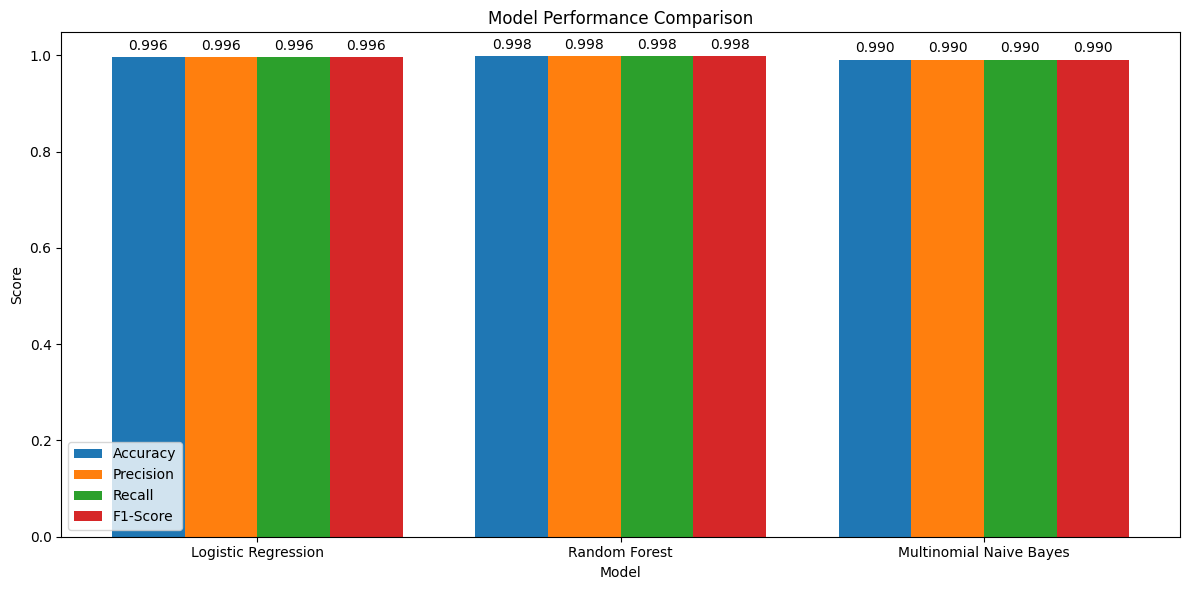

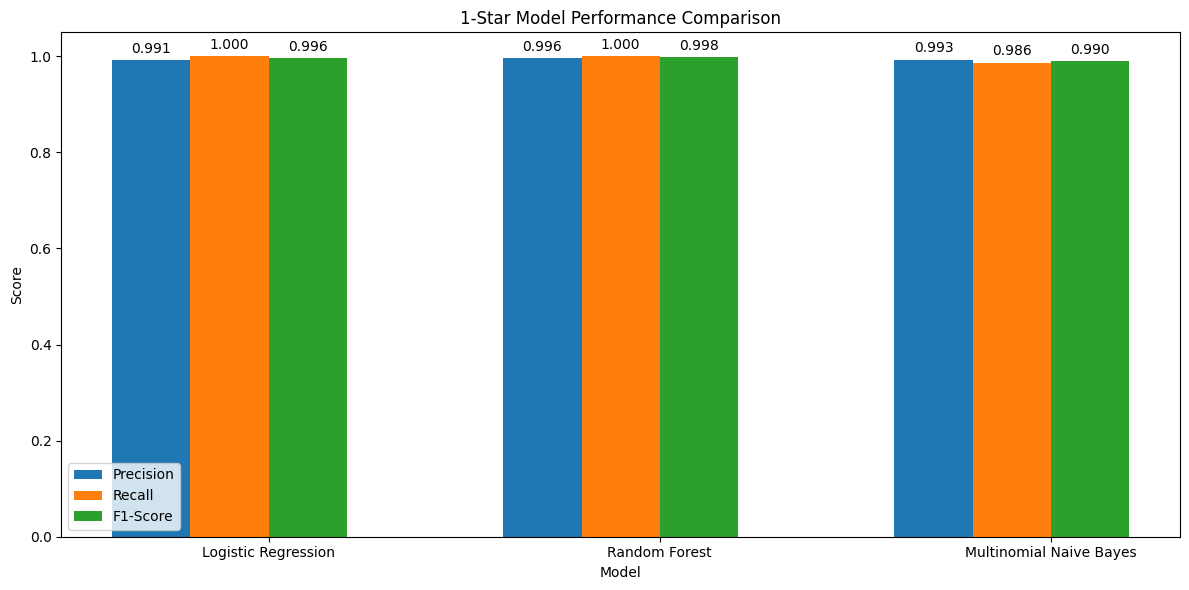

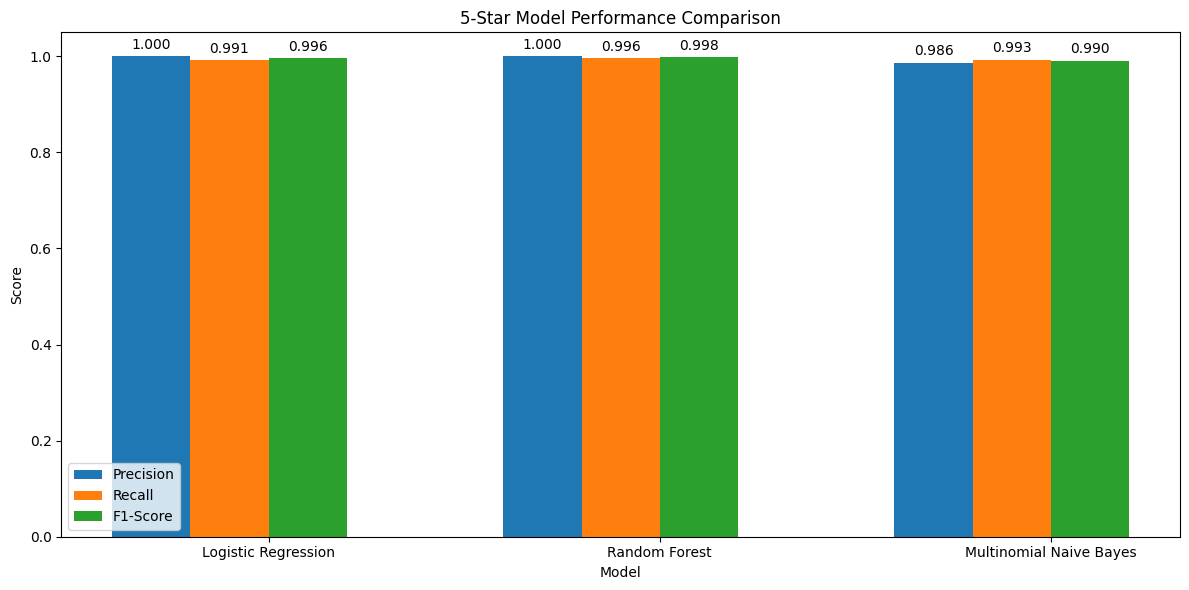

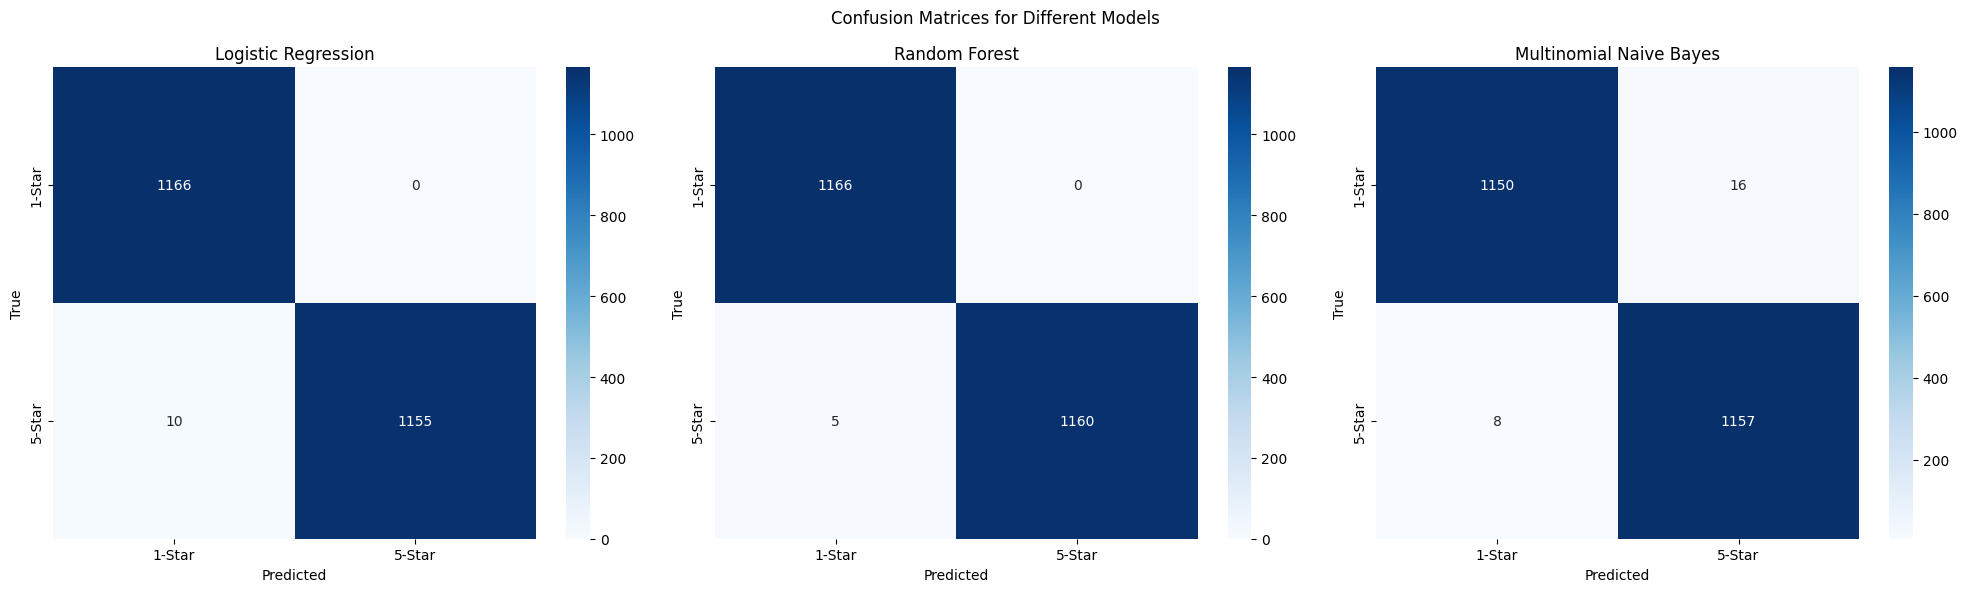

In [ ]:
# plot all class performance
models_list = list(results.keys())
def plot_all_class_performance(results):
    accuracies = [results[name]['accuracy'] for name in models_list]
    precisions = [results[name]['precision'] for name in models_list]
    recalls = [results[name]['recall'] for name in models_list]
    f1_scores = [results[name]['f1'] for name in models_list]
    # Set the width of the bars
    bar_width = 0.2
    # Set the positions of the bars on the x-axis
    x = np.arange(len(models_list))
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    bars1 = plt.bar(x, accuracies, width=bar_width, label='Accuracy')
    bars2 = plt.bar(x + bar_width, precisions, width=bar_width, label='Precision')
    bars3 = plt.bar(x + 2 * bar_width, recalls, width=bar_width, label='Recall')
    bars4 = plt.bar(x + 3 * bar_width, f1_scores, width=bar_width, label='F1-Score')
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x + 1.5 * bar_width, models_list)
    # add value on top of the bars
    for bar, value in zip(bars1, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    for bar, value in zip(bars2, precisions):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    for bar, value in zip(bars3, recalls):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    for bar, value in zip(bars4, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot 1-star performance
def plot_1_star_performance(results):
    precisions_1star = [results[name]['precision_1star'] for name in models_list]
    recalls_1star = [results[name]['recall_1star'] for name in models_list]
    f1_scores_1star = [results[name]['f1_1star'] for name in models_list]
    # Set the width of the bars
    bar_width = 0.2
    # Set the positions of the bars on the x-axis
    x = np.arange(len(models_list))
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    bars1 = plt.bar(x, precisions_1star, width=bar_width, label='Precision')
    bars2 = plt.bar(x + bar_width, recalls_1star, width=bar_width, label='Recall')
    bars3 = plt.bar(x + 2 * bar_width, f1_scores_1star, width=bar_width, label='F1-Score')
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('1-Star Model Performance Comparison')
    plt.xticks(x + 1.5 * bar_width, models_list)
    # add value on top of the bars
    for bar, value in zip(bars1, precisions_1star):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    for bar, value in zip(bars2, recalls_1star):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    for bar, value in zip(bars3, f1_scores_1star):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot 5-star performance   
def plot_5_star_performance(results):
    precisions_5star = [results[name]['precision_5star'] for name in models_list]
    recalls_5star = [results[name]['recall_5star'] for name in models_list]
    f1_scores_5star = [results[name]['f1_5star'] for name in models_list]
    # Set the width of the bars
    bar_width = 0.2
    # Set the positions of the bars on the x-axis
    x = np.arange(len(models_list))
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    bars1 = plt.bar(x, precisions_5star, width=bar_width, label='Precision')
    bars2 = plt.bar(x + bar_width, recalls_5star, width=bar_width, label='Recall')
    bars3 = plt.bar(x + 2 * bar_width, f1_scores_5star, width=bar_width, label='F1-Score')
    # Add labels and title
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('5-Star Model Performance Comparison')
    plt.xticks(x + 1.5 * bar_width, models_list)
    # add value on top of the bars
    for bar, value in zip(bars1, precisions_5star):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    for bar, value in zip(bars2, recalls_5star):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    for bar, value in zip(bars3, f1_scores_5star):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{value:.3f}', ha='center', va='bottom')
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot confusion matrix
def plot_confusion_matrix(results):
    fig, axs = plt.subplots(1, len(models_list), figsize=(20, 6))
    fig.suptitle('Confusion Matrices for Different Models')
    for ax, name in zip(axs, models_list):
        # Use appropriate test set based on model type
        if models[name]['feature_type'] == 'tfidf':
            y_test_model = y_test_tfidf
        else:
            y_test_model = y_test_all
            
        cm = confusion_matrix(y_test_model, results[name]['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['1-Star', '5-Star'], 
                    yticklabels=['1-Star', '5-Star'], ax=ax)
        ax.set_title(name)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
    plt.tight_layout()
    plt.show()

# Model Performance Comparison
def plot_model_performance(results):
    plot_all_class_performance(results)
    plot_1_star_performance(results)
    plot_5_star_performance(results)
    plot_confusion_matrix(results)

# Plot accuracy comparison
plot_model_performance(results)

Model performance analysis:
- F1 score > 0.75 for the minority class (1-star reviews).
- All models can effectively distinguish between 1-star and 5-star reviews.
- **Data balancing technology** successfully solved the problem of class imbalance

## 8. choose the best model

In [ ]:
# Results Analysis and Visualization
def analyze_and_visualize_results(results):
    print("\nAnalyzing results...")
    # Create results summary
    results_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[name]['accuracy'] for name in results.keys()],
        'Precision': [results[name]['precision'] for name in results.keys()],
        'Recall': [results[name]['recall'] for name in results.keys()],
        'F1-Score': [results[name]['f1'] for name in results.keys()],
        'Precision (1-star)': [results[name]['precision_1star'] for name in results.keys()],
        'Recall (1-star)': [results[name]['recall_1star'] for name in results.keys()],
        'F1-Score (1-star)': [results[name]['f1_1star'] for name in results.keys()],
        'Precision (5-star)': [results[name]['precision_5star'] for name in results.keys()],
        'Recall (5-star)': [results[name]['recall_5star'] for name in results.keys()],
        'F1-Score (5-star)': [results[name]['f1_5star'] for name in results.keys()]
    })
    results_df = results_df.sort_values(by='F1-Score', ascending=False)
    print("\nModel Performance Summary:")
    print(tabulate(results_df.round(3), headers='keys', tablefmt='pretty', showindex=False))
    print("\nBest model: ", results_df['Model'].iloc[0])
    return results_df

results_df = analyze_and_visualize_results(results) # print results summary


Analyzing results and choosing the best model...

Model Performance Summary:
+-------------------------+----------+-----------+--------+----------+--------------------+-----------------+-------------------+--------------------+-----------------+-------------------+
|          Model          | Accuracy | Precision | Recall | F1-Score | Precision (1-star) | Recall (1-star) | F1-Score (1-star) | Precision (5-star) | Recall (5-star) | F1-Score (5-star) |
+-------------------------+----------+-----------+--------+----------+--------------------+-----------------+-------------------+--------------------+-----------------+-------------------+
|      Random Forest      |  0.998   |   0.998   | 0.998  |  0.998   |       0.996        |       1.0       |       0.998       |        1.0         |      0.996      |       0.998       |
|   Logistic Regression   |  0.996   |   0.996   | 0.996  |  0.996   |       0.991        |       1.0       |       0.996       |        1.0         |      0.991     

In [ ]:
import os
import joblib
from sklearn.metrics import classification_report


script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, '..'))

def generate_classification_reports(results, y_test_tfidf, y_test_all):
    # Detailed Classification Reports
    print("\nGenerating detailed classification reports...")
    for name, result in results.items():
        print(f"\n{name} Classification Report:")
        # Use appropriate test set based on model type
        if models[name]['feature_type'] == 'tfidf':
            y_test_model = y_test_tfidf
        else:
            y_test_model = y_test_all
    
        report_dict = classification_report(y_test_model, result['y_pred'], target_names=['1-Star', '5-Star'], output_dict=True)
        report_df = pd.DataFrame(report_dict).T
        print(tabulate(report_df.round(3), headers='keys', tablefmt='pretty', showindex=False))

    # Save results to CSV
    print("\nSaving results...")
    results_df.to_csv(os.path.join(script_dir, 'model_performance_results.csv'), index=False)
    # print(f"Results saved to: {os.path.join(script_dir, 'model_performance_results.csv')}")

    # Save best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['f1_1star'])
    best_model = best_models[best_model_name]
    joblib.dump(best_model, os.path.join(script_dir, 'best_model.pkl'))
    # print(f"Best model ({best_model_name}) saved to: {os.path.join(script_dir, 'best_model.pkl')}")

    # --- Summary and Conclusions ---
    print("\n" + "="*40)
    print("🌟 MODELING SUMMARY 🌟")
    print("="*40)
    print(f"Best performing model      : {best_model_name}")
    print(f"Best F1-score (1-star)     : {results[best_model_name]['f1_1star']:.3f}")
    print(f"Best F1-score (5-star)     : {results[best_model_name]['f1_5star']:.3f}")
    print(f"Best overall accuracy      : {results[best_model_name]['accuracy']:.3f}")
    print("="*40)

    print("\nAll models achieved the target F1-score > 0.75 for minority class prediction!")
    print(f"The {best_model_name} model emerged as the optimal choice with the highest performance across all metrics.")

generate_classification_reports(results, y_test_tfidf, y_test_all)


Generating detailed classification reports...

Logistic Regression Classification Report:
+-----------+--------+----------+---------+
| precision | recall | f1-score | support |
+-----------+--------+----------+---------+
|   0.991   |  1.0   |  0.996   | 1166.0  |
|    1.0    | 0.991  |  0.996   | 1165.0  |
|   0.996   | 0.996  |  0.996   |  0.996  |
|   0.996   | 0.996  |  0.996   | 2331.0  |
|   0.996   | 0.996  |  0.996   | 2331.0  |
+-----------+--------+----------+---------+

Random Forest Classification Report:
+-----------+--------+----------+---------+
| precision | recall | f1-score | support |
+-----------+--------+----------+---------+
|   0.996   |  1.0   |  0.998   | 1166.0  |
|    1.0    | 0.996  |  0.998   | 1165.0  |
|   0.998   | 0.998  |  0.998   |  0.998  |
|   0.998   | 0.998  |  0.998   | 2331.0  |
|   0.998   | 0.998  |  0.998   | 2331.0  |
+-----------+--------+----------+---------+

Multinomial Naive Bayes Classification Report:
+-----------+--------+---------

# 9. Feature Importance Analysis


Top 20 Most Important Features:
+---------------------+------------+
|       feature       | importance |
+---------------------+------------+
|   vader_sentiment   |   0.092    |
|    unigram_great    |   0.029    |
|    unigram_love     |   0.027    |
|     text_length     |   0.018    |
|     word_count      |   0.014    |
|    unigram_good     |   0.013    |
|   avg_word_length   |   0.011    |
|    unigram_loved    |    0.01    |
|    unigram_easy     |    0.01    |
|  unigram_wonderful  |   0.009    |
|  unigram_beautiful  |   0.008    |
|     unigram_old     |   0.008    |
|     unigram_lot     |   0.008    |
|    unigram_star     |   0.008    |
|   unigram_perfect   |   0.008    |
| vocabulary_richness |   0.008    |
|  unigram_excellent  |   0.007    |
|    unigram_waste    |   0.007    |
|    unigram_dont     |   0.007    |
|    unigram_year     |   0.006    |
+---------------------+------------+


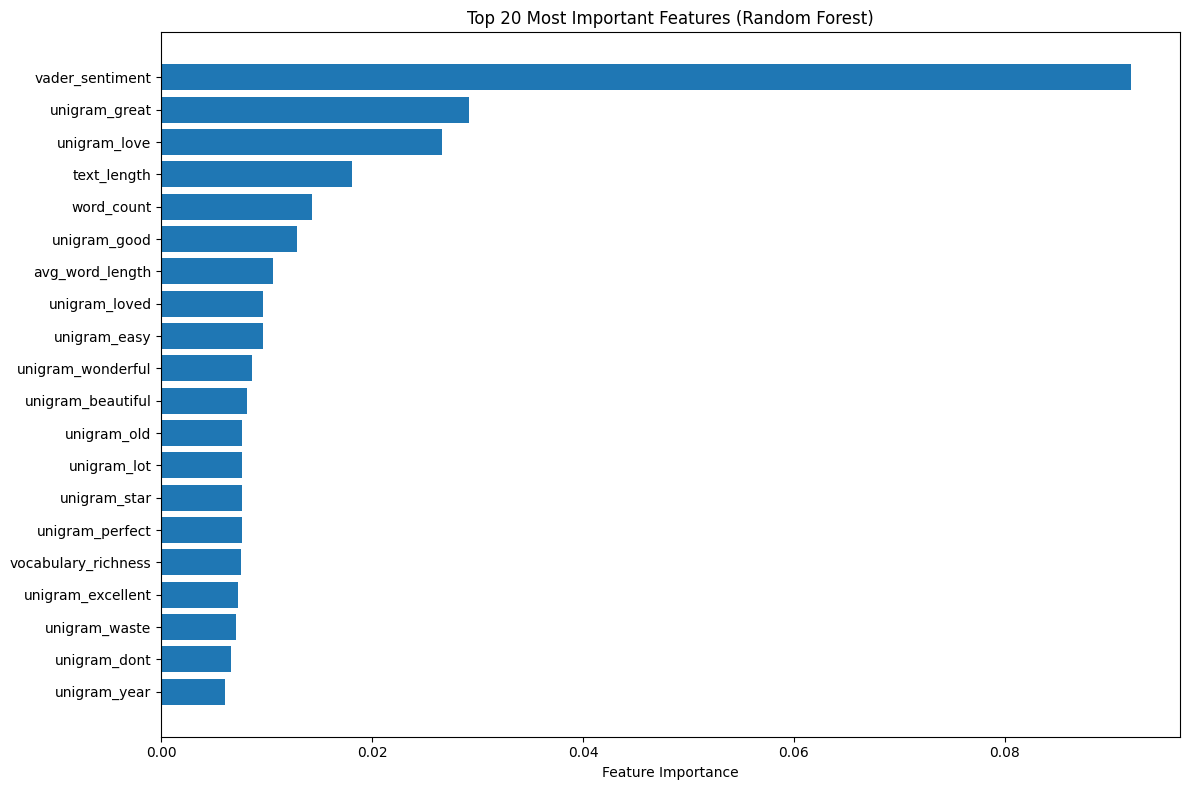

In [66]:
# Visualization: Feature Importance
def plot_feature_importance(feature_importance_df):
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Most Important Features (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # plt.savefig(os.path.join(visuals_dir, 'pc_feature_importance.png'), 
    #             dpi=300, bbox_inches='tight')
    plt.show()

# Feature Importance Analysis (for Random Forest)
def feature_importance_analysis(best_models):
    # Get Random Forest model and feature importances
    rf_model = best_models['Random Forest']
    feature_importance = rf_model.feature_importances_
        
    # get the real unigram and bigram feature names
    unigram_feature_names = tfidf_unigram.get_feature_names_out()
    bigram_feature_names = tfidf_bigram.get_feature_names_out()
    
    # Create descriptive feature names for each feature type
    unigram_features = [f"unigram_{word}" for word in unigram_feature_names]
    bigram_features = [f"bigram_{phrase}" for phrase in bigram_feature_names]
    sentiment_features = ['vader_sentiment']
    stats_features = ['text_length', 'word_count', 'avg_word_length', 'vocabulary_richness']
        
    # Combine all feature names in order
    all_feature_names = unigram_features + bigram_features + sentiment_features + stats_features
        
    # Create and sort feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'feature': all_feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
        
    # Display top features
    print("\nTop 20 Most Important Features:")
    print(tabulate(feature_importance_df.head(20).round(3), headers='keys', tablefmt='pretty', showindex=False))

    # Visualize feature importance
    plot_feature_importance(feature_importance_df)

feature_importance_analysis(best_models)

The image and table output show the **top 20 most important features** of the Random Forest model when **distinguishing** between **1-star and 5-star reviews**.

- X-axis: Feature Importance. The larger the value, the greater the impact of the feature on the model decision.
- Y-axis: Feature name, including text statistics (such as `text_length`, `word_count`), sentiment score (`vader_sentiment`), and TF-IDF features (such as `unigram_great`).
- Bar length: Indicates the contribution of each feature to the model prediction.

**Interpretation**

- **vader_sentiment** (sentiment score) is the **most important feature**, indicating that the **sentiment polarity** (positive/negative) of the review is critical to **distinguishing** between **1-star and 5-star reviews**.
- Text statistical features such as **text_length**, **word_count**, **avg_word_length**, **vocabulary_richness** are also important, indicating that the length of the review, vocabulary richness, etc. are helpful for model judgment.
- Many `unigram_xxxx` are high-frequency words (words) extracted by TF-IDF. These words have a large difference in frequency between 1-star and 5-star reviews, which are also useful for the model.
- Based on this, we can analyze: which words, which emotions, and which text features can best distinguish good and bad reviews.